FOOD CLASSIFICATION AND CALORIES ESTIMATION

In [73]:
"""Food Classification and Calories Estimation
Develop a model that can accurately recognize food items from images and estimate their calorie content, enabling users to track their dietary intake and make informed food choices.

Dataset :- https://www.kaggle.com/dansbecker/food-101"""





import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [74]:
#check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name)

2.15.0
<function gpu_device_name at 0x7f4fd56796c0>


In [75]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [76]:
get_data_extract()

Dataset already exists


In [77]:
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [78]:
os.listdir('food-101/images')

['crab_cakes',
 'french_fries',
 'ceviche',
 'strawberry_shortcake',
 'miso_soup',
 'pho',
 'baklava',
 'foie_gras',
 'grilled_salmon',
 'panna_cotta',
 'pork_chop',
 'huevos_rancheros',
 'takoyaki',
 'spaghetti_carbonara',
 'macarons',
 'oysters',
 'beet_salad',
 'gnocchi',
 'cheesecake',
 'seaweed_salad',
 'falafel',
 'beef_tartare',
 'guacamole',
 'risotto',
 'clam_chowder',
 'hummus',
 'caesar_salad',
 'edamame',
 'frozen_yogurt',
 'gyoza',
 'fried_rice',
 'peking_duck',
 'ice_cream',
 'ramen',
 'cheese_plate',
 'pulled_pork_sandwich',
 'red_velvet_cake',
 'club_sandwich',
 'filet_mignon',
 'chocolate_mousse',
 'chicken_quesadilla',
 'waffles',
 'carrot_cake',
 'chicken_curry',
 'baby_back_ribs',
 'cannoli',
 'tiramisu',
 'bread_pudding',
 'tacos',
 'deviled_eggs',
 'poutine',
 'creme_brulee',
 'hot_dog',
 'pancakes',
 'eggs_benedict',
 'shrimp_and_grits',
 'sushi',
 'caprese_salad',
 'pad_thai',
 'samosa',
 'ravioli',
 'chocolate_cake',
 'croque_madame',
 'lobster_roll_sandwich',


In [79]:
os.listdir('food-101/meta')

['train.json',
 'test.json',
 'classes.txt',
 'test.txt',
 'labels.txt',
 'train.txt']

In [80]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [81]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


Visualize random image from each of the classes

In [82]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [84]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [12]:


# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [13]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [14]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [15]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c


Total number of samples in test folder
25250


create a subset of datawith few classes(3) -train_mini and test_mini for experimenting

In [85]:
os.chdir('/')

In [86]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [87]:
foods_sorted

['baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich

In [88]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))


In [89]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini/'
src_test = 'test'
dest_test = 'test_mini/'

In [91]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)
#print("Total number of samples in train folder")
#!find train_mini -type d -or -type f -printf '.' | wc -c
print('\n')

print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)
#print("Total number of samples in test folder")
#!find test_mini -type d -or -type f -printf '.' | wc -c

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [92]:
import os

def count_files_and_folders(directory):
    """Counts the total number of files and folders in a directory."""
    count = 0
    for _, _, files in os.walk(directory):
        count += len(files)
    return count

#for train_mini
train_dir = 'train_mini'  # Replace with the actual directory path
total_count = count_files_and_folders(train_dir)
print("Total number of samples in train folder:", total_count)

#fro test_mini
test_dir = 'test_mini'  # Replace with the actual directory path
total_count = count_files_and_folders(test_dir)
print("Total number of samples in test folder:", total_count)

Total number of samples in train folder: 2250
Total number of samples in test folder: 750


Fine tune ResNet50 Pretrained model using Food 101 dataset

In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

K.clear_session()

# Parameters
n_classes = 3
img_width, img_height = 224, 224
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250
nb_validation_samples = 750
batch_size = 16

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# No augmentation for validation set
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


# Build the model
resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(3, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']  # Add metrics for evaluation
)


# Callbacks to save the best model and log training history
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=10,  # Number of training epochs
    callbacks=[checkpointer, csv_logger]  # Use the defined callbacks
)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 1.0606 - accuracy: 0.4987 
Epoch 1: val_loss improved from inf to 2.62264, saving model to best_model_3class.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 1662s 12s/step - loss: 1.0606 - accuracy: 0.4987 - val_loss: 2.6226 - val_accuracy: 0.3315
Epoch 2/10
140/140 [==============================] - ETA: 0s - loss: 0.7593 - accuracy: 0.6835 
Epoch 2: val_loss improved from 2.62264 to 2.32440, saving model to best_model_3class.hdf5
140/140 [==============================] - 1636s 12s/step - loss: 0.7593 - accuracy: 0.6835 - val_loss: 2.3244 - val_accuracy: 0.3342
Epoch 3/10
140/140 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.7677 
Epoch 3: val_loss did not improve from 2.32440
140/140 [==============================] - 1591s 11s/step - loss: 0.6204 - accuracy: 0.7677 - val_loss: 2.4589 - val_accuracy: 0.3315
Epoch 4/10
140/140 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.8124 
Epoch 4: val_loss did not improve from 2.32440
140/140 [==============================] - 1564s 11s/step - loss: 0.5199 - accuracy: 0.8124 - val_loss: 2.3841 - val_accur

In [24]:
class_map_3=train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

In [94]:
model.save('best_model_3class.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Visualize the accuracy and loss plots

In [29]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


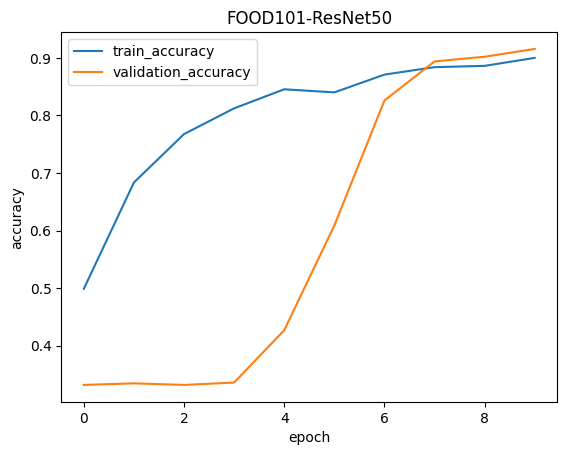

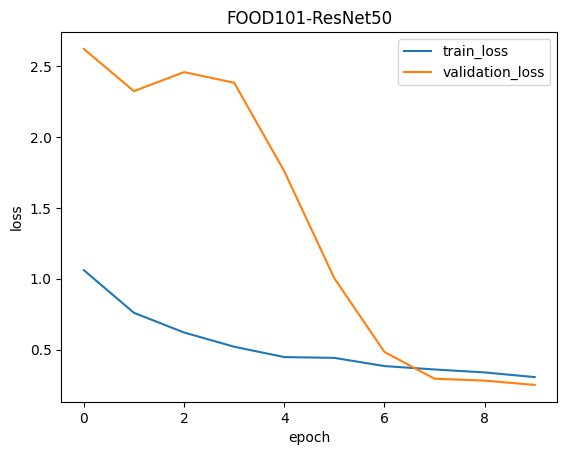

In [30]:
plot_accuracy(history,'FOOD101-ResNet50')
plot_loss(history,'FOOD101-ResNet50')

Predicting classes for new images from internet using the best trained model


In [96]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 3.04 s, sys: 114 ms, total: 3.16 s
Wall time: 2.97 s


In [48]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def predict_class(model, img_path, food_list, show=True):
    """
    Predicts the class of an image using the provided model.

    Args:
        model: The pre-trained Keras model.
        img_path: Path to the image to be predicted.
        food_list: A list of food classes corresponding to the model's output.
        show: Whether to display the image with prediction.

    Returns:
        The predicted class name.
    """
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()  # Ensure food_list is sorted for consistent indexing
    pred_value = food_list[index]

    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(f"Prediction: {pred_value}")  # Display the prediction as title
        plt.show()

    return pred_value

1/1 [==============================] - 0s 200ms/step


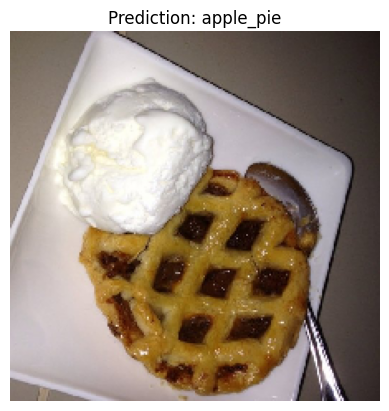

apple_pie


In [51]:
prediction = predict_class(model, '/train_mini/apple_pie/1043283.jpg', food_list)
print(prediction)  # This will print the predicted class name

In [97]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()


1/1 [==============================] - 0s 183ms/step


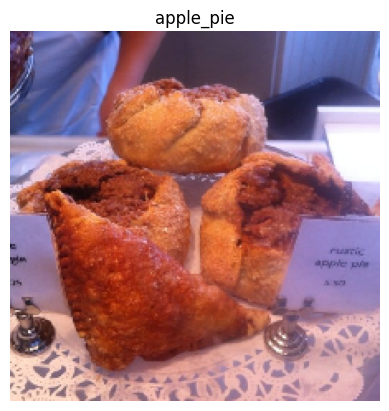

1/1 [==============================] - 0s 179ms/step


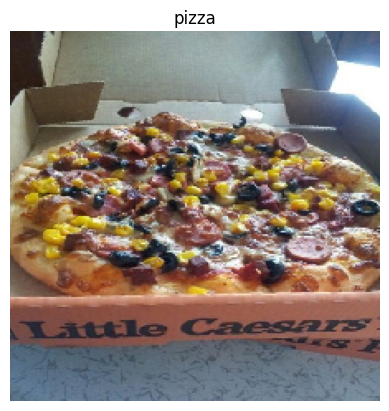

1/1 [==============================] - 0s 185ms/step


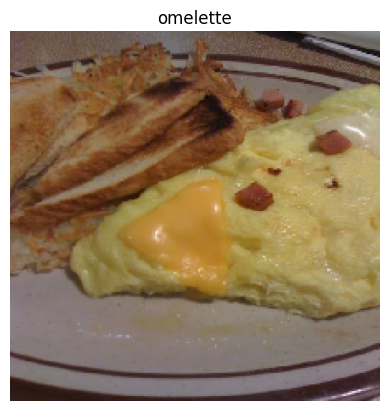

In [105]:
# Make a list of downloaded images and test the trained model
images = []
images.append('/content/train/apple_pie/2379223.jpg')
images.append('/content/train/pizza/2569760.jpg')
images.append('/content/train/omelette/1063811.jpg')
predict_class(model_best, images, True)

In [44]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.